# Double pendulum using Lagrange's equation

Here is the first problem of Physics 5300 Final.

The notebook is based on Dr. Furnstahl's work.



In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from IPython.display import Image
import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

In [4]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

## Euler-Lagrange equation

For a simple pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi} = \frac{\partial\mathcal L}{\partial\phi}
 \quad\Longrightarrow\quad
 m L^2 \ddot \phi = -mgL\sin\phi
  \ \mbox{or}\ \ddot\phi = - \omega_0^2\sin\phi = 0
  \;.
\end{align}$


For a system consists of two pendulums, the generalized coordinates are $\theta_1$ and $\theta_2$, as shown in the schematic picture above. Then, the cartisian positions with vertical and horizontal components ($x$ and $y$) would be following:

$$\begin{align} 
& x_1 = L_1 sin(\theta_1) \\
& y_1 = L_1 cos(\theta_1) \\
& x_2 = x_1 + L_2 sin(\theta_2) \\
& y_2 = y_1 + L_2 cos(\theta_2)
\end{align}$$

And similarly, for their time derivatives: 

$$\begin{align}
& \dot x_1 = L_1 \dot\theta_1 cos(\theta_1) \\
& \dot y_1 = - L_1 \dot\theta_1 sin(\theta_1) \\
& \dot x_2 = L_1 \dot\theta_1 cos(\theta_1) + L_2 \dot\theta_2 cos(\theta_2) \\
& \dot y_2 = - L_1 \dot\theta_1 sin(\theta_1) - L_2 \dot\theta_2 sin(\theta_2) 
\end{align}$$


After putting those equations as toolbox, we can write kinetic energy and potential energy for the system:

$$\begin{align}
T &= \frac{1}{2}m_1(\dot x_1 + \dot y_1)^2 + \frac{1}{2}m_2(\dot x_2 + \dot y_2)^2 \\
  &= \frac{1}{2}m_1 L_1^2\dot\theta_1^2 + \frac{1}{2}m_2 \left[L_1^2\dot\theta_1^2 + L_2^2\dot\theta_2^2 + 2L_1 L_2 cos(\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2\right] \\
U &= -m_1 g y_1 - m_2 g y_2 \\
  &= -(m_1 + m_2) L_1 g cos(\theta_1) - m_2 L_2 g cos(\theta_2)
\end{align}$$

The Lagrangian is given by $\mathcal{L} = T - U$:

$$
\mathcal{L} = \frac{1}{2}(m_1 + m_2)L_1^2\dot\theta_1^2 + \frac{1}{2}m_2 L_2^2\dot\theta_2^2 + m_2 L_1 L_2 \dot\theta_1 \dot\theta_2 cos(\theta_1 - \theta_2) + (m_1 + m_2) L_1 g cos(\theta_1) + m_2 g L_2 cos(\theta_2)
$$

According to previous expression for Euler-Lagrangian equation, we have:
$$
\begin{align}
0 &= (m_1 + m_2) L_1 \ddot\theta_1 + m_2 L_2 \ddot\theta_2 cos(\theta_1 - \theta_2) + m_2 L_2 \dot\theta_2^2 sin(\theta_1 - \theta_2) + g(m_1 + m_2) sin(\theta_1) \\
0 &= m_2 L_2 \ddot\theta_2 + m_2 L_1 \ddot\theta_1 cos(\theta_1 - \theta_2) - m_2 L_1 \dot\theta_1^2 sin(\theta_1 - \theta_2) + m_2 g sin(\theta_2)
\end{align}
$$

Therefore, we can solve for $\ddot\theta_1$ and $\ddot\theta_2$ as following: 
$$
\begin{align}
&\ddot\theta_1 = \frac{m_2 g \mbox{sin}(\theta_2) \mbox{cos}(\theta_1 - \theta_2) - m_2 \mbox{sin}(\theta_1 - \theta_2)\left[L_1 \dot\theta_1^2 \mbox{cos}(\theta_1 - \theta_2) + L_2 \dot\theta_2^2\right] - (m_1 + m_2) g \mbox{sin}(\theta_1)}{L_1 \left[m_1 + m_2 \mbox{sin}^2(\theta_1 - \theta_2)\right]} \\
&\ddot\theta_2 = \frac{(m_1 + m_2)\left[L_1 \dot\theta_1^2 \mbox{sin}(\theta_1 - \theta_2) - g \mbox{sin}(\theta_2) + g \mbox{sin}(\theta_1)\mbox{cos}(\theta_1 - \theta_2)\right] + m_2 L_2 \dot\theta_2^2 \mbox{sin}(\theta_1 - \theta_2)\mbox{cos}(\theta_1 - \theta_2)}{L_2\left[m_1 + m_2 \mbox{sin}^2(\theta_1 - \theta_2)\right]}
\end{align}
$$

And these two equations are used in following codes.

## DoublePendulum class and utility functions

In [5]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of one simple pendulum
        
    L2 : float
        length of the other simple pendulum
        
    g : float
        gravitational acceleration at the earth's surface       
        
    mass1: float
        mass of one pendulum
        
    mass2: float
        mass of the other pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.m1 = m1
        self.m2 = m2
        self.g = g

    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = theta1 and y[1] = theta1_dot
                                      y[2] = theta2 and y[3] = theta2_dot
            
        Returns
        -------
        
        """
        theta1, theta1_dot, theta2, theta2_dot = y
        c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)
        denom = (self.m1 + self.m2 * s**2)
        
        theta1_ddot = (self.m2 * self.g * np.sin(theta2) * c \
                      -self.m2 * s * (self.L1 * theta1_dot**2 * c + self.L2 * theta2_dot**2) \
                      -(self.m1 + self.m2) * self.g * np.sin(theta1) ) / self.L1 / denom
        
        theta2_ddot = ( (self.m1 + self.m2) * (self.L1 * theta1_dot**2 * s \
                      - self.g * np.sin(theta2) + self.g * np.sin(theta1) * c ) 
                      + self.m2 * self.L2 * theta2_dot**2 * s * c ) / self.L2 / denom
        
        return [theta1_dot, theta1_ddot, theta2_dot, theta2_ddot]
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        
        theta1, theta1_dot, theta2, theta2_dot = solution.y

        return theta1, theta1_dot, theta2, theta2_dot
    
    def calc_E(y):
        """
        This calculates the total energy of the system
        """
        
        th1, th1d, th2, th2d = y.T
        V = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
        T = 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L2*th2d)**2 + (L2*th2d)**2 + \
            2*L1*L2*th1d*th2d*np.cos(th1-th2))
        
        return T + V

In [6]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [7]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Part a1: Double simple pendulum plots

Here $\theta_1(t)$ and $\theta_2(t)$ are given by the following initial conditions:

$\theta_1(0) = \frac{\pi}{2}$

$\dot\theta_1(0) = 0$

$\theta_2(0) = \pi$

$\dot\theta_2(0) = 0$

In [8]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50. #50
delta_t = 0.05 #0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1. #1
L2 = 1.
m1 = 1.
m2 = 1.
g = 1.

# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, m1=m1, m2=m2, g=g)


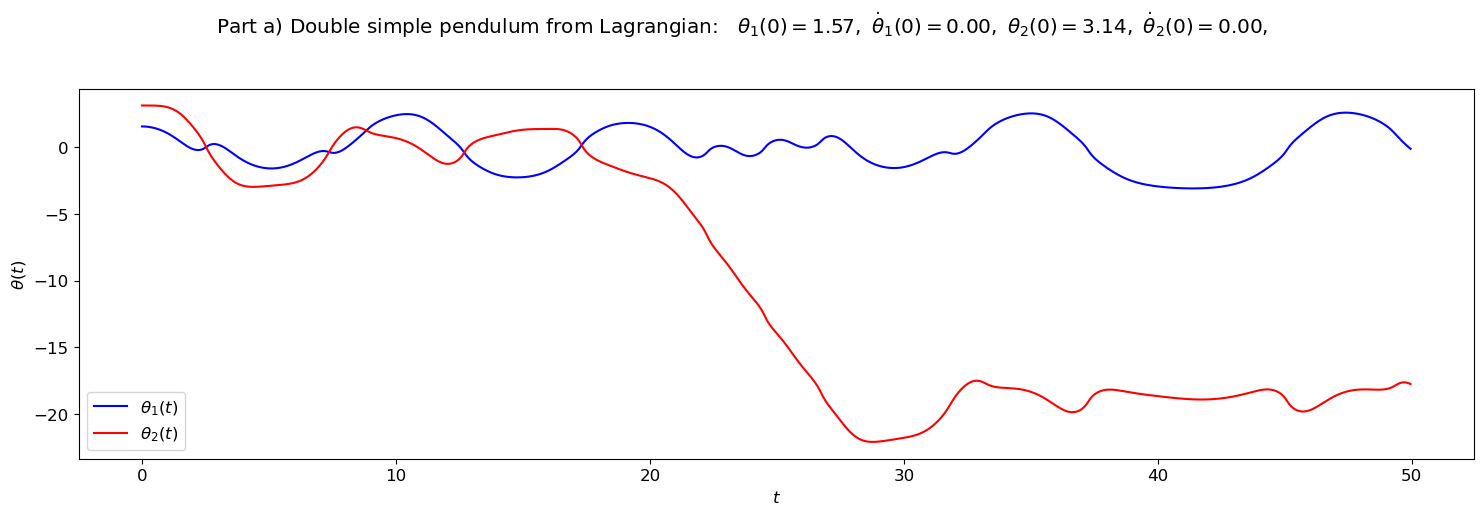

In [9]:
# Initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.


theta1, theta1_dot, theta2, theta2_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Part a) Double simple pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'


fig.suptitle(overall_title, va='baseline')
    

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=r'$\theta_1(t)$', 
            ax=ax_a)    
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            color='red',
            label=r'$\theta_2(t)$', 
            ax=ax_a)  
  

fig.tight_layout()
fig.savefig('double_simple_pendulum_Lagrange.png', bbox_inches='tight')  

## Part a2: Double simple pendulum plots

Here $\theta_1(t)$ and $\theta_2(t)$ are given by the following initial conditions:

$\theta_1(0) = \frac{\pi}{3}$

$\dot\theta_1(0) = 0$

$\theta_2(0) = \pi$

$\dot\theta_2(0) = 0$

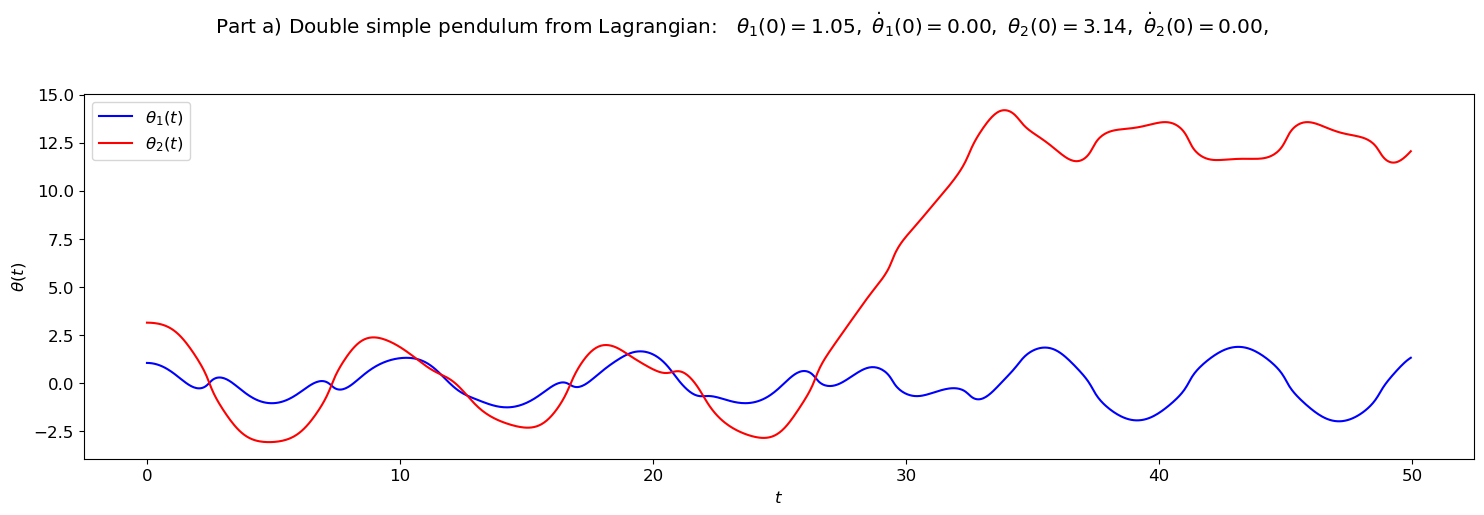

In [10]:
# Initial conditions
theta1_0 = np.pi/3
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.


theta1, theta1_dot, theta2, theta2_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Part a) Double simple pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'


fig.suptitle(overall_title, va='baseline')
    

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=r'$\theta_1(t)$', 
            ax=ax_a)    
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            color='red',
            label=r'$\theta_2(t)$', 
            ax=ax_a)  
  

fig.tight_layout()
fig.savefig('double_simple_pendulum_Lagrange.png', bbox_inches='tight')  

## Part b1: Chaotic behavior simulation
Here $\theta_1(t)$ and $\theta_2(t)$ are given by the following initial conditions:

$\theta_1(0) = \frac{\pi}{2}$

$\dot\theta_1(0) = 0$

$\theta_2(0) = \pi$

$\dot\theta_2(0) = 0$

But when solve the Lagrange Eq1uation, give $\theta_2(t)$ a tiny displacement abnd see what will happened



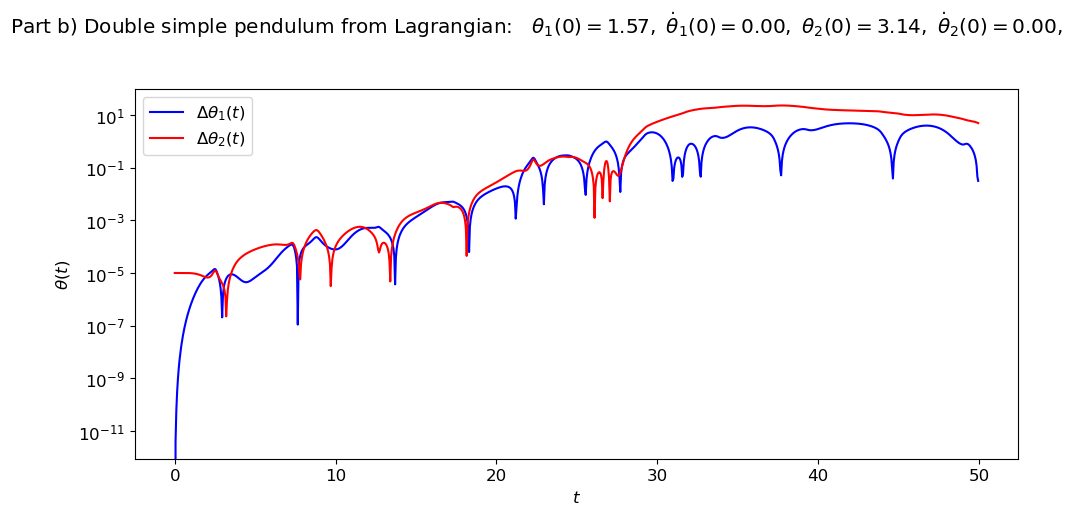

In [11]:
# Initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.


theta1, theta1_dot, theta2, theta2_dot = \
dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

theta1b, theta1b_dot, theta2b, theta2b_dot = \
dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Part b) Double simple pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'


fig.suptitle(overall_title, va='baseline')
    

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            semilogy = True,
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop] - theta2b[start : stop]), 
            color='red',
            semilogy = True,
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)  
  

fig.tight_layout()

## Part b1: Chaotic behavior simulation
Here $\theta_1(t)$ and $\theta_2(t)$ are given by the following initial conditions:

$\theta_1(0) = \frac{\pi}{3}$

$\dot\theta_1(0) = 0$

$\theta_2(0) = \pi$

$\dot\theta_2(0) = 0$

But when solve the Lagrange Eq1uation, give $\theta_2(t)$ a tiny displacement abnd see what will happened



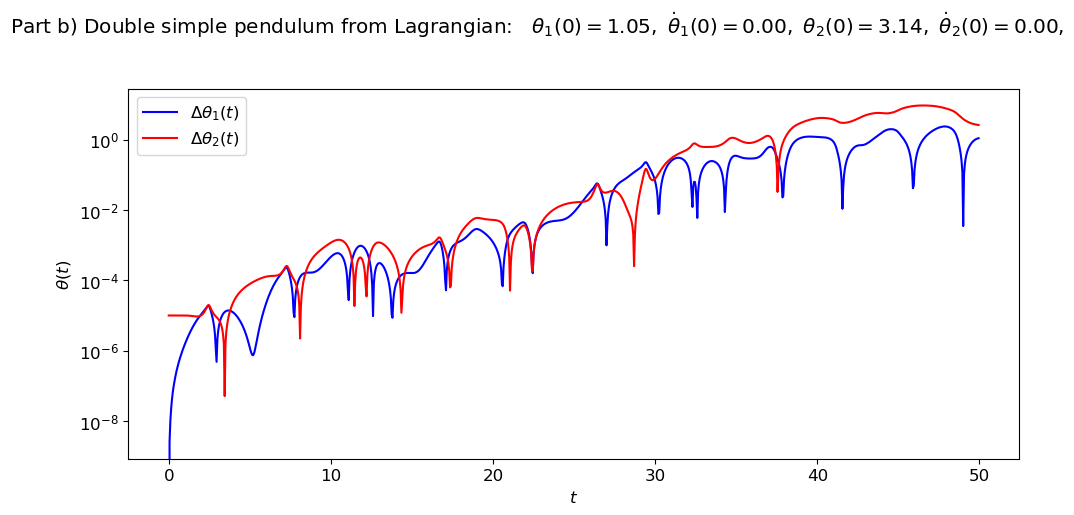

In [12]:
# Initial conditions
theta1_0 = np.pi/3
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.


theta1, theta1_dot, theta2, theta2_dot = \
dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

theta1b, theta1b_dot, theta2b, theta2b_dot = \
dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Part b) Double simple pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'


fig.suptitle(overall_title, va='baseline')
    

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            semilogy = True,
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop] - theta2b[start : stop]), 
            color='red',
            semilogy = True,
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)  
  

fig.tight_layout()


From b1 and b2 , we can see that when t is large both $\Delta\theta_1$ and $\Delta\theta_2$ are increasing fastly as timer goes by , which verifies the chaotic behavior of the system after a very tiny disturbance is given to the initial position of the 2nd pendulum.


## Part e): Animation

In [13]:
from matplotlib import animation, rc
from IPython.display import HTML

def xy_coords(x0, y0, theta, L):
    """
    Use x and y as the generalized coordinates replacing theta and L
    """
    
    x = x0 + L * np.sin(theta)
    y = y0 - L * np.cos(theta)
    
    return x, y

In [14]:
%%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

fig_anim = plt.figure(figsize=(10,5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)  
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)



x0, y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0,
                        'o', markersize=6,
                        color='black')

x1, y1 = xy_coords(x0, y0, theta1[0], dp1.L1)
pt1_anim, = ax_anim.plot(x1, y1,
                        'o', markersize=12,
                        color='blue')
ln1_anim, = ax_anim.plot([x0, x1], [y0, y1], color='blue', lw=3)
x2, y2 = xy_coords(x1, y1, theta2[0], dp1.L2)
pt2_anim, = ax_anim.plot(x2, y2,
                        'o', markersize=12,
                        color='blue')
ln2_anim, = ax_anim.plot([x1, x2], [y1, y2], color='blue', lw=3)

x1b, y1b = xy_coords(x0, y0, theta1b[0], dp1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b,
                        'o', markersize=12,
                        color='red')
ln1b_anim, = ax_anim.plot([x0, x1b], [y0, y1b], color='red', lw=3)
x2b, y2b = xy_coords(x1b, y1b, theta2b[0], dp1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b,
                        'o', markersize=12,
                        color='red')
ln2b_anim, = ax_anim.plot([x1b, x2b], [y1b, y2b], color='red', lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [15]:
def animate_pendulum(i):
    
    i_skip = i * 2
    
    x0, y0 = 0., 0.
    pt0_anim.set_data(x0, y0)
    
    x1, y1 =xy_coords(x0, y0, theta1[i_skip], dp1.L1)
    pt1_anim.set_data(x1, y1)
    ln1_anim.set_data([x0, x1], [y0, y1])
    x2, y2 =xy_coords(x1, y1, theta2[i_skip], dp1.L2)
    pt2_anim.set_data(x2, y2)
    ln2_anim.set_data([x1, x2], [y1, y2])
    
    x1b, y1b =xy_coords(x0, y0, theta1b[i_skip], dp1.L1)
    pt1b_anim.set_data(x1b, y1b)
    ln1b_anim.set_data([x0, x1b], [y0, y1b])
    x2b, y2b =xy_coords(x1b, y1b, theta2b[i_skip], dp1.L2)
    pt2b_anim.set_data(x2b, y2b)
    ln2b_anim.set_data([x1b, x2b], [y1b, y2b])
    
    return (pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim,
           pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)

In [16]:
frame_interval = 20.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim,
                              animate_pendulum,
                              init_func=None,
                              frames=frame_number,
                              interval=frame_interval,
                              blit=True,
                              repeat=False)

In [17]:
HTML(anim.to_jshtml())

IndexError: index 1002 is out of bounds for axis 0 with size 1001